# STA2536 - Final Project: Prediction of Volatility

## Import Packages

In [77]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, recall_score, f1_score, confusion_matrix

from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras import metrics, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

In [65]:
projectData = '/Users/liuyuzhou/desktop/MFI Courses/STA2536/Projects/Project 4/'

In [68]:
os.chdir(projectData)
files = os.listdir('data/')
files.sort()
print(len(files))

1334


In [67]:
stocks = list(set([file[:-15] for file in files]))
stocks.sort()
print(stocks)

['1-s2.0-S0378778819', 'AAL', 'FB', 'GOOG', 'INTC', 'SIRI', 'VOD']


In [5]:
data = loadmat('data/INTC_2018-03-06.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

In [10]:
data['data'].dtype

dtype([('Eventime', 'O'), ('SellVolume', 'O'), ('SellPrice', 'O'), ('BuyVolume', 'O'), ('BuyPrice', 'O'), ('NumberMO', 'O'), ('VolumeMO', 'O')])

## Data Preparation

In [69]:
def read_feature(stock_list, feature_list, stack_all = False):
    if stack_all == True:
        X = np.empty((1320, 78, len(feature_list)))
        
        for i, f in enumerate(feature_list):
            X[:,:,i] = pd.read_csv(f+'.csv', index_col=None).iloc[:, 1:].values
            
        Y = pd.read_csv('label.csv', index_col=None).iloc[:, 1:].values.astype(int)
    return X, Y    


def split_data(x, y, seed=66):
    np.random.seed(seed)
    
    n_days = x.shape[1]
    n_features = x.shape[2]
    
    x_train = np.empty((1170, n_days, n_features))
    y_train = np.empty((1170, n_days))
    
    index_1 = np.random.choice(np.arange(0,248),248,replace=False)
    index_2 = np.random.choice(np.arange(248,480),232,replace=False)
    index_3 = np.random.choice(np.arange(480,576),96,replace=False)
    index_4 = np.random.choice(np.arange(576,824),248,replace=False)
    index_5 = np.random.choice(np.arange(824,1072),248,replace=False)
    index_6 = np.random.choice(np.arange(1072,1320),248,replace=False)
    
    test_indexes = np.hstack([index_1[0:28], 
                              index_2[0:27], 
                              index_3[0:11], 
                              index_4[0:28], 
                              index_5[0:28], 
                              index_6[0:28]])
    x_test = x[test_indexes, :, :]
    y_test = y[test_indexes, :]
    
    for i in range(5):
        train_indexes = np.hstack([index_1[(28+i*44):(28+(i+1)*44)],
                                   index_2[(27+i*41):(27+(i+1)*41)],
                                   index_3[(11+i*17):(11+(i+1)*17)],
                                   index_4[(28+i*44):(28+(i+1)*44)],
                                   index_5[(28+i*44):(28+(i+1)*44)],
                                   index_6[(28+i*44):(28+(i+1)*44)]])
        assert len(train_indexes)==234
        x_train[i*234:(i+1)*234,:,:] = x[train_indexes, :, :]
        y_train[i*234:(i+1)*234,:] = y[train_indexes, :]

    return x_train, x_test, y_train, y_test
    
    
def reshape_data(x, y, n_lags):
    n_days = x.shape[0] 
    n_lens = x.shape[1] - n_lags
    n_lagged_features = x.shape[2] * n_lags
    x_hat = np.empty((n_days, n_lens, n_lagged_features))
    
    for d in range(n_days):
        for l in range(n_lens):
            try:
                x_hat[d,l,:] = np.reshape(x[d,l:l+n_lags,:], (1,1,n_lagged_features))
            except:
                print('Index Error')
                
    y_hat = y[:,n_lags:]
    assert y_hat.shape[1]==n_lens
    return x_hat.reshape(-1,n_lagged_features), y_hat.flatten()

In [70]:
stocks = ['AAL', 'FB', 'GOOG', 'INTC', 'SIRI', 'VOD']

original_features = ['SellPrice', 'BuyPrice', 'SellVolume', 'BuyVolume', 'NumberMO', 'VolumeMO']

features = ['event time',
            'limit buy price','limit sell price', 'limit buy volume', 'limit sell volume',
            'market buy count', 'market sell count', 'market buy volume', 'market sell volume', 
            'spread', 'volume difference', 'maximum limit sell price', 'minimum limit buy price', 
            'MBV std', 'MSV std', 'label']

len(features)

16

In [71]:
X_all, Y_all = read_feature(stocks, features, stack_all=True)
print(X_all.shape)

(1320, 78, 16)


In [9]:
aal = X_all[:248,:,:]
fb =  X_all[248:480,:,:]
goog = X_all[480:576,:,:]
intc = X_all[576:824,:,:]
siri = X_all[824:1072,:,:]
vod = X_all[1072:,:,:]

In [72]:
X_train, X_test, Y_train, Y_test = split_data(X_all, Y_all)
print(X_train.shape)
print(X_test.shape)

(1170, 78, 16)
(150, 78, 16)


## Exploratory Data Analysis

In [12]:
def LogNormalize(x, p):
    y = np.log(1 + x / np.mean(x[x!=0],axis=0) )
    
    return Normalize(y, p)

def NormalizeFeatures(X, p):
    
    x = np.empty((X.shape[0]*X.shape[1], X.shape[2]-1))
    for i in range(15):
        x[:,i] = LogNormalize(X[:,:,i].flatten(), p)
     
    return x

In [13]:
aal_norm = NormalizeFeatures(aal, 0.1)
fb_norm = NormalizeFeatures(fb, 0.1)
goog_norm = NormalizeFeatures(goog, 0.1)
intc_norm = NormalizeFeatures(intc, 0.1)
siri_norm = NormalizeFeatures(siri, 0.1)
vod_norm = NormalizeFeatures(vod, 0.1)

In [14]:
# Plot empirical distribution of mid prices for each stock
def plots():
    plt.figure(figsize=(16,18))
    plt.tight_layout()
    
    for i in range(1,15):
        plt.subplot(5,3,i)
        df = pd.DataFrame([aal_norm[:,i], 
                           fb_norm[:,i],
                           goog_norm[:,i],
                           intc_norm[:,i],
                           siri_norm[:,i],
                           vod_norm[:,i]])
        df = df.T
        sns.kdeplot(data=df, bw=0.4).set(xlim=(-4,4))
        plt.title(features[i], fontsize=12)
        plt.legend(stocks)
        
    plt.savefig('test1.jpg', dpi=150)
    plt.show()

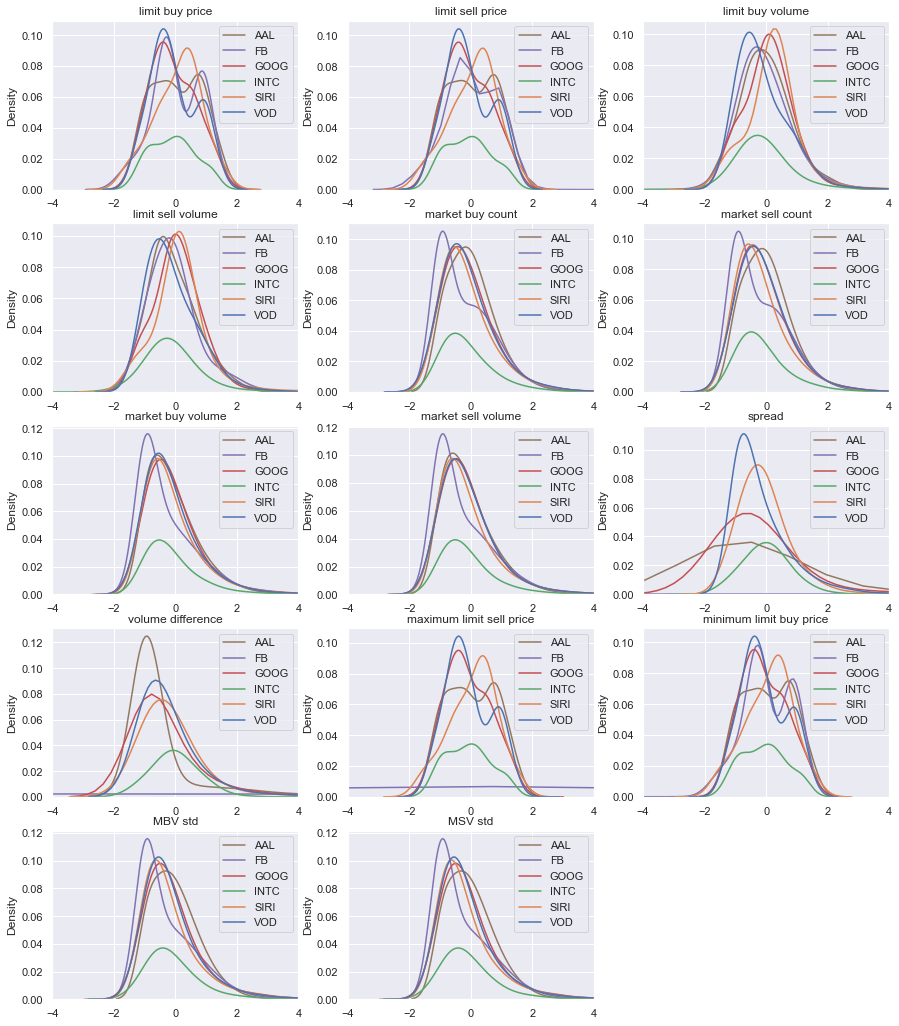

In [423]:
plots()

## Model 1: &ensp; XGBoost

In [73]:
def cv_grid_search(X, Y, params, lags):
    grids = []
    
    for lag in lags:
        X_, Y_ = reshape_data(X, Y, lag)
        
        pipeline = Pipeline([('scaler', StandardScaler()),
                             ('clf', XGBClassifier())])
        #print(pipeline.get_params().keys())
        print('---------Grid Search---------')
        grid = GridSearchCV(estimator=pipeline,
                            param_grid=params,
                            scoring='f1_weighted',
                            cv=5,
                            n_jobs=1,
                            verbose=2)
        grid.fit(X_, Y_)
        grids.append(grid)
        print('1 round accomplised.')
    return grids

#### Standard scaled XGBoost with grid search for optimal hyperparameters

In [ ]:
param_grid = [
    {
        'clf__learning_rate': [0.005, 0.01],
        'clf__max_depth': [3, 5, 7],
        'clf__n_estimators': [75, 100, 125],
        'clf__min_child_weight': [1, 2, 3]
    }
]

lag_list = [3, 5, 7]

results_xgb = cv_grid_search(X_all, Y_all, param_grid, lag_list)

In [27]:
for gs in results_xgb:
    print('Best estimator parameters: {} with best f1 score {}'.format(gs.best_params_, gs.best_score_))

Best estimator parameters: {'clf__learning_rate': 0.005, 'clf__max_depth': 3, 'clf__min_child_weight': 1, 'clf__n_estimators': 75} with best f1 score 0.26334837998084404
Best estimator parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__min_child_weight': 3, 'clf__n_estimators': 75} with best f1 score 0.26934365707131114
Best estimator parameters: {'clf__learning_rate': 0.005, 'clf__max_depth': 3, 'clf__min_child_weight': 1, 'clf__n_estimators': 125} with best f1 score 0.2739441355891741


#### Optimized hyperparameters for XGBoost: lag=7, max_depth=3, min_child_weight=1, n_estimators=125

In [75]:
n_lags_xgb = 5
X_train_xgb, Y_train_xgb = reshape_data(X_train, Y_train, n_lags_xgb)
X_test_xgb, Y_test_xgb = reshape_data(X_test, Y_test, n_lags_xgb)

In [76]:
pipe_xgb = Pipeline([('scaler', StandardScaler()),
                     ('clf', XGBClassifier(n_estimators=125, max_depth=5, min_child_weight=1))])

In [57]:
# Five-fold Cross Validation
scores_xgb = cross_validate(pipe_xgb, X_train_xgb, Y_train_xgb, scoring=['accuracy', 'recall_macro', 'f1_macro'], cv=5, return_train_score=False)

print('5-fold cv accuracy of XGBoost (with lag = {})'.format(n_lags_xgb))
print('Average accuracy: {:.2%}'.format(scores_xgb['test_accuracy'].mean()))
print('Average recall: {:.4}'.format(scores_xgb['test_recall_macro'].mean()))
print('Average f-1: {:.4}'.format(scores_xgb['test_f1_macro'].mean()))

5-fold cv accuracy of XGBoost (with lag = 5)
Average accuracy: 35.21%
Average recall: 0.3449
Average f-1: 0.3261


Test accuracy: 37.14%
Test recall: 0.337388730343566
Test f1: 0.33664658847932893


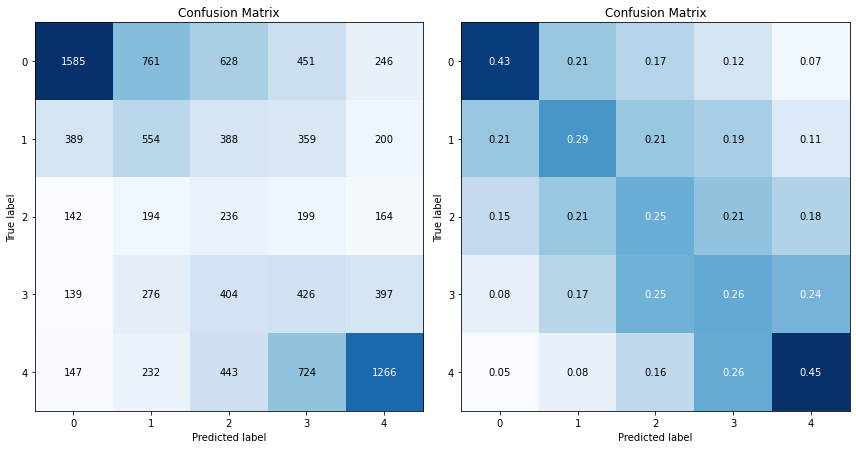

In [79]:
# Test set performance
pipe_xgb.fit(X_train_xgb, Y_train_xgb)
Y_pred_xgb = pipe_xgb.predict(X_test_xgb)

acc_xgb = accuracy_score(Y_pred_xgb, Y_test_xgb)
recall_xgb = recall_score(Y_pred_xgb, Y_test_xgb, average='macro')
f1_xgb = f1_score(Y_pred_xgb, Y_test_xgb, average='macro')
print('Test accuracy: {:.2%}'.format(acc_xgb))
print('Test recall: {:.2%}'.format(recall_xgb))
print('Test f1: {:.2%}'.format(f1_xgb))

# Confusion Matrix
conf_mat = confusion_matrix(Y_pred_xgb, Y_test_xgb)
plot_conf_mat(conf_mat, ['0','1','2','3','4'])

## Model 2: &ensp; Neural Nerwork

In [33]:
def nn_model(lag):
    # Construct the model
    clf_nn = Sequential()
    clf_nn.add(Dense(64, input_shape = (lag*16, ), activation='relu'))
    clf_nn.add(Dropout(0.1))
    clf_nn.add(Dense(64, activation='relu'))
    clf_nn.add(Dense(5, activation='softmax'))

    # Compile the model
    sgd = optimizers.SGD(lr=0.01, decay=0.02)
    clf_nn.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
    return clf_nn


def cv_grid_search_nn(X, Y, model, params):
    pipeline = Pipeline([('scaler', StandardScaler()),
                         ('clf', model)])
    kfold = StratifiedKFold(n_splits=5)
    
    print('---------Grid Search---------')
    search = GridSearchCV(estimator=pipeline,
                        param_grid=params,
                        scoring='accuracy',
                        cv=kfold,
                        n_jobs=1,
                        verbose=2)
    search.fit(X_, Y_)
    print('Accomplished')
    return search

In [28]:
def plot_conf_mat(conf_mat, classes):

    fig = plt.figure(figsize=(12,15))
    
    ax = plt.subplot(1,2,1)
    
    ax.imshow(conf_mat, interpolation='nearest', cmap = plt.cm.Blues)
    
    ax.set(xticks=np.arange(conf_mat.shape[1]),
           yticks=np.arange(conf_mat.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    fmt = 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black") 
    
    
    conf_mat_nrm = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]
    
    ax = plt.subplot(1,2,2)
    
    ax.imshow(conf_mat_nrm, interpolation='nearest', cmap = plt.cm.Blues)
    
    ax.set(xticks=np.arange(conf_mat_nrm.shape[1]),
           yticks=np.arange(conf_mat_nrm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    
    fmt = '.2f'
    thresh = conf_mat_nrm.max() / 2.
    for i in range(conf_mat_nrm.shape[0]):
        for j in range(conf_mat_nrm.shape[1]):
            ax.text(j, i, format(conf_mat_nrm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat_nrm[i, j] > thresh else "black")
            
            
    fig.tight_layout()      
    
    plt.show()



In [58]:
import warnings
warnings.filterwarnings('ignore')

#### Standard scaled Neural Network with grid search for optimal hyperparameters

In [29]:
param_grid_nn = [
    {
        'clf__epochs': [25, 50, 75, 100, 125],
        'clf__batch_size': [16, 32, 64, 128],
    }
]
lag_list_nn = [3, 5, 7]

param_grid_nn2 = [
    {
        'clf__epochs': [90, 100, 110],
        'clf__batch_size': [32, 64, 128],
    }
]
lag_list_nn2 = [2, 3, 4, 5]

In [136]:
# Grid search for parameters
grids = []

for l in lag_list_nn2:
    X_, Y_ = reshape_data(X_all, Y_all, l)
    X_train_, X_test_, Y_train_, Y_test_ = train_test_split(X_, Y_, test_size=0.2, random_state=66)

    model = KerasClassifier(build_fn=nn_model, lag=l, verbose=0)
    grid = cv_grid_search_nn(X_train_, Y_train_, model, param_grid_nn2)
    grids.append(grid)
    
    print('Lag = '+str(l)+' accomplised.')

---------Grid Search---------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] clf__batch_size=32, clf__epochs=90 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.3min
[CV] clf__batch_size=32, clf__epochs=90 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.6min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.3min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.3min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.5min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.6min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.5min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.5min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 44.7min finished


Accomplished
Lag = 2 accomplised.
---------Grid Search---------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] clf__batch_size=32, clf__epochs=90 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.3min
[CV] clf__batch_size=32, clf__epochs=90 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.3min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.3min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.3min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.3min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.4min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.4min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.5min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 40.6min finished


Accomplished
Lag = 3 accomplised.
---------Grid Search---------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] clf__batch_size=32, clf__epochs=90 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.2min
[CV] clf__batch_size=32, clf__epochs=90 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.2min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.2min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.2min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.2min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.4min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.4min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.4min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 39.1min finished


Accomplished
Lag = 4 accomplised.
---------Grid Search---------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] clf__batch_size=32, clf__epochs=90 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.2min
[CV] clf__batch_size=32, clf__epochs=90 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.2min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.3min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.2min
[CV] clf__batch_size=32, clf__epochs=90 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=90, total= 1.2min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.4min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.4min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .............. clf__batch_size=32, clf__epochs=100, total= 1.4min
[CV] clf__batch_size=32, clf__epochs=100 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 39.9min finished


Accomplished
Lag = 5 accomplised.


In [137]:
for gs in grids:
    print('Best estimator parameters: {} with best acc score {}'.format(gs.best_params_, gs.best_score_))

Best estimator parameters: {'clf__batch_size': 64, 'clf__epochs': 110} with best acc score 0.29547448165869217
Best estimator parameters: {'clf__batch_size': 128, 'clf__epochs': 100} with best acc score 0.2953838383838384
Best estimator parameters: {'clf__batch_size': 32, 'clf__epochs': 110} with best acc score 0.29854627354627356
Best estimator parameters: {'clf__batch_size': 32, 'clf__epochs': 110} with best acc score 0.30218970527189704


#### Optimized hyperparameters for NN: lag=5, batch_size=32, epochs=100

In [30]:
n_lags_nn = 5
X_train_nn, Y_train_nn = reshape_data(X_train, Y_train, n_lags_nn)
X_test_nn, Y_test_nn = reshape_data(X_test, Y_test, n_lags_nn)

In [34]:
# Compile the model
clf_nn = KerasClassifier(build_fn=nn_model, lag=n_lags_nn, batch_size=32, epochs=100, verbose=0)
pipe_nn = Pipeline([('scaler', StandardScaler()),
                    ('clf', clf_nn)])

In [59]:
# 5-fold Cross Validation
scores_nn = cross_validate(pipe_nn, X_train_nn, Y_train_nn, scoring=['accuracy', 'recall_macro', 'f1_macro'], cv=5, return_train_score=False)

print('5-fold cv accuracy of Neural Network (with lag = {})'.format(n_lags_nn))
print('Average accuracy: {:.2%}): '.format(scores_nn['test_accuracy'].mean()))
print('Average recall: {:.4}'.format(scores_nn['test_recall_macro'].mean()))
print('Average F-1: {:.4}'.format(scores_nn['test_f1_macro'].mean()))

5-fold cv accuracy of Neural Network (with lag = 5)
Average accuracy: 32.27%): 
Average recall: 0.3131
Average F-1: 0.2713


Test accuracy: 33.74%
Test recall: 0.29765004154540303
Test f1: 0.2911913123059462


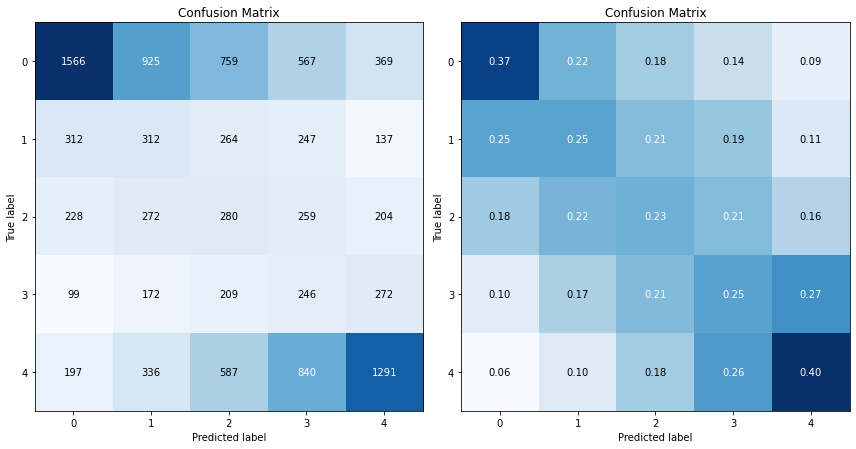

In [80]:
# Test set performance
pipe_nn.fit(X_train_nn, Y_train_nn)

Y_pred_nn = pipe_nn.predict(X_test_nn)

acc_nn = accuracy_score(Y_pred_nn, Y_test_nn)
recall_nn = recall_score(Y_pred_nn, Y_test_nn, average='macro')
f1_nn = f1_score(Y_pred_nn, Y_test_nn, average='macro')
print('Test accuracy: {:.2%}'.format(acc_nn))
print('Test recall: {}'.format(recall_nn))
print('Test f1: {}'.format(f1_nn))

# Confusion Matrix
conf_mat = confusion_matrix(Y_pred_nn, Y_test_nn)
plot_conf_mat(conf_mat, ['0','1','2','3','4'])

## Model 3: &ensp; LSTM

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin


class AddAxis(BaseEstimator, TransformerMixin):
    def __init__(self, axis=1):
        self.axis=axis

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = np.expand_dims(X, axis=self.axis)
        return X

In [37]:
def lstm_model(lag, GRU=False):
    # Construct the model
    clf_lstm = Sequential()
    clf_lstm.add(LSTM(128, input_shape = (1, lag*16), return_sequences=True))
    clf_lstm.add(BatchNormalization())
    clf_lstm.add(Dropout(0.2))
    clf_lstm.add(LSTM(128))
    clf_lstm.add(BatchNormalization())
    clf_lstm.add(Dense(5, activation='softmax'))

    # Compile the model
    sgd = optimizers.SGD(lr=0.01, decay=0.01)
    clf_lstm.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
    return clf_lstm


def cv_grid_search_lstm(X, Y, model, params):
    pipeline = Pipeline([('scaler', StandardScaler()),
                         ('axis', AddAxis()),
                         ('clf', model)])
        
    print('---------Grid Search---------')
    search = GridSearchCV(estimator=pipeline,
                        param_grid=params,
                        scoring='accuracy',
                        cv=5,
                        n_jobs=1,
                        verbose=2)
    search.fit(X, Y)
    print('Accomplished')
    return search

In [38]:
param_grid_lstm = [
    {
        #'__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
        'clf__epochs': [25, 50, 75, 100, 125],
        'clf__batch_size': [32, 64, 128],
    }
]
lag_list_lstm = [3, 5, 7]

param_grid_lstm2 = [
    {
        'clf__epochs': [40, 50, 60],
        'clf__batch_size': [32, 64, 128],
    }
]
lag_list_lstm2 = [2, 3, 4, 5]

In [30]:
grids_lstm = []

for l in lag_list_lstm2:
    X_, Y_ = reshape_data(X_all, Y_all, l)
    X_train_, X_test_, Y_train_, Y_test_ = train_test_split(X_, Y_, test_size=0.2, random_state=66)

    model = KerasClassifier(build_fn=lstm_model, lag=l, verbose=0)
    grid = cv_grid_search_lstm(X_train_, Y_train_, model, param_grid_lstm2)
    grids_lstm.append(grid)
    print('Lag = '+str(l)+' accomplised.')

---------Grid Search---------
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] clf__batch_size=32, clf__epochs=25 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=25 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=25 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=25 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=25 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=50, total= 4.4min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=50, total= 4.3min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=50, total= 4.4min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 346.2min finished


Accomplished
Lag = 3 accomplised.
---------Grid Search---------
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] clf__batch_size=32, clf__epochs=25 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=25 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=25 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=25 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=25 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.2min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=50, total= 4.3min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=50, total= 4.3min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=50, total= 4.3min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 341.8min finished


Accomplished
Lag = 5 accomplised.
---------Grid Search---------
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] clf__batch_size=32, clf__epochs=25 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.1min
[CV] clf__batch_size=32, clf__epochs=25 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.0min
[CV] clf__batch_size=32, clf__epochs=25 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.1min
[CV] clf__batch_size=32, clf__epochs=25 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.1min
[CV] clf__batch_size=32, clf__epochs=25 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=25, total= 2.1min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=50, total= 4.1min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=50, total= 4.1min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] ............... clf__batch_size=32, clf__epochs=50, total= 4.1min
[CV] clf__batch_size=32, clf__epochs=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 335.4min finished


Accomplished
Lag = 7 accomplised.


In [34]:
for i in grids_lstm:
    print(i.best_params_, i.best_score_)

{'clf__batch_size': 32, 'clf__epochs': 125} 0.2596464646464646
{'clf__batch_size': 64, 'clf__epochs': 50} 0.27636986301369865
{'clf__batch_size': 64, 'clf__epochs': 100} 0.2716816047801963


#### Optimized hyperparameters for LSTM: lag=5, batch_size=64, epochs=50

In [39]:
n_lags_lstm = 5
X_train_lstm, Y_train_lstm = reshape_data(X_train, Y_train, n_lags_lstm)
X_test_lstm, Y_test_lstm = reshape_data(X_test, Y_test, n_lags_lstm)
print(X_train_lstm.shape)

(85410, 80)


In [42]:
# Compile the model
clf_lstm = KerasClassifier(build_fn=lstm_model, lag=n_lags_lstm, batch_size=64, epochs=50, verbose=0)
pipe_lstm = Pipeline([('scaler', StandardScaler()),
                      ('axis', AddAxis()),
                      ('clf', clf_lstm)])

In [60]:
# 5-fold cross validation
scores_lstm = cross_validate(pipe_lstm, X_train_lstm, Y_train_lstm, scoring=['accuracy', 'recall_macro', 'f1_macro'], cv=5, return_train_score=False)

print('5-fold cv accuracy of LSTM (with lag = {})'.format(n_lags_lstm))
print('Average accuracy: {:.2%}): '.format(scores_lstm['test_accuracy'].mean()))
print('Average recall: {:.4}'.format(scores_lstm['test_recall_macro'].mean()))
print('Average F-1: {:.4}'.format(scores_nn['test_f1_macro'].mean()))

5-fold cv accuracy of LSTM (with lag = 5)
Average accuracy: 33.67%): 
Average recall: 0.3277
Average F-1: 0.2713


Test accuracy: 34.62%
Test recall: 0.2966302970937545
Test f1: 0.29411295010271177


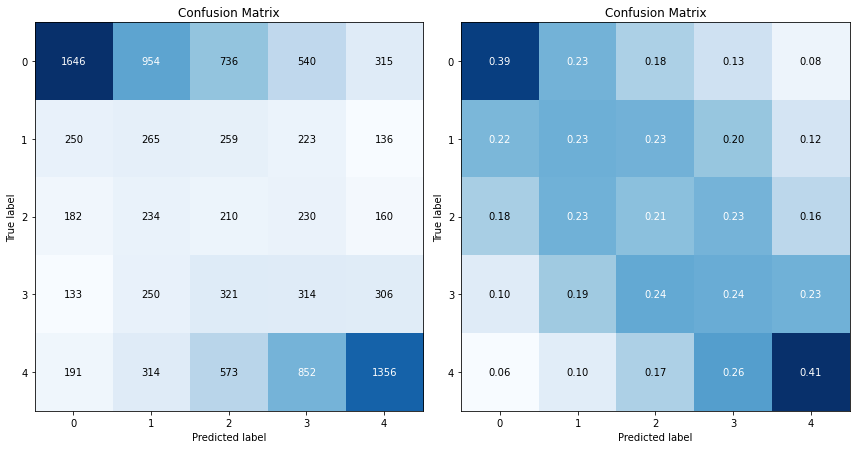

In [82]:
# Test set performance
pipe_lstm.fit(X_train_lstm, Y_train_lstm)

Y_pred_lstm = pipe_lstm.predict(X_test_lstm)
acc_lstm = accuracy_score(Y_pred_lstm, Y_test_lstm)
recall_lstm = recall_score(Y_pred_lstm, Y_test_lstm, average='macro')
f1_lstm = f1_score(Y_pred_lstm, Y_test_lstm, average='macro')
print('Test accuracy: {:.2%}'.format(acc_lstm))
print('Test recall: {}'.format(recall_lstm))
print('Test f1: {}'.format(f1_lstm))

# Confusion Matrix
conf_mat = confusion_matrix(Y_pred_lstm, Y_test_lstm)
plot_conf_mat(conf_mat, ['0','1','2','3','4'])

## Model 4: &ensp; LSTM - GRU

In [92]:
def lstm_gru_model(lag):
    # Construct the model
    clf_gru = Sequential()
    clf_gru.add(GRU(256, input_shape = (1, lag*12), return_sequences=True))
    clf_gru.add(BatchNormalization())
    clf_gru.add(Dropout(0.2))
    clf_gru.add(LSTM(256))
    clf_gru.add(BatchNormalization())
    clf_gru.add(Dense(64,  activation = 'relu'))
    clf_gru.add(Dense(5, activation='softmax'))

    # Compile the model
    sgd = optimizers.SGD(lr=0.01, decay=0.01)
    clf_gru.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
    return clf_gru

In [193]:
clf_gru = KerasClassifier(build_fn=lstm_gru_model, lag=n_lags_lstm, batch_size=64, epochs=50, verbose=0)
pipe_gru = Pipeline([('scaler', StandardScaler()),
                     ('axis', AddAxis()),
                     ('clf', clf_gru)])

In [200]:
# 5-fold cross validation
scores_gru = cross_val_score(pipe_gru, X_train_lstm, Y_train_lstm, cv=5)
print('5-fold cv accuracy (with lag = {}): {}'.format(n_lags_lstm, scores_lstm))
print('Average Score: {:.2%}'.format(np.mean(scores_lstm)))

5-fold cv accuracy (with lag = 5): [0.34000704 0.32098114 0.34375367 0.35054442 0.34024119]
Average Score: 33.91%


Test set accuracy (with lag = 5): 34.91%


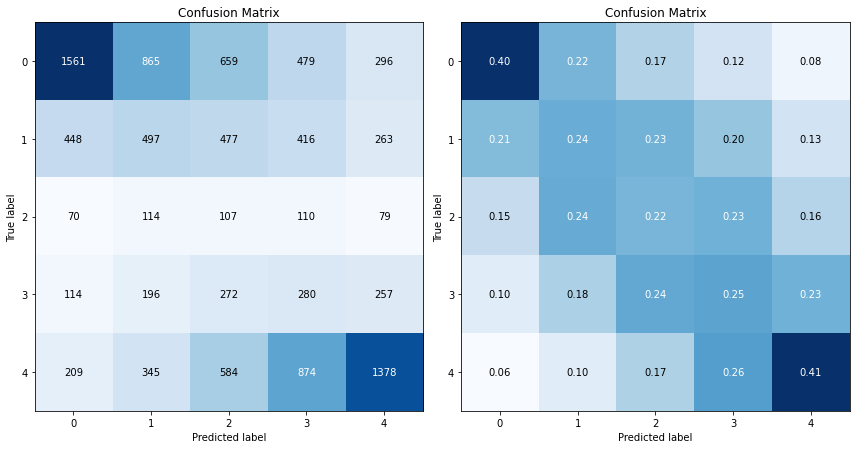

In [197]:
# Test set performance
pipe_gru.fit(X_train_lstm, Y_train_lstm)

Y_pred_gru = pipe_gru.predict(X_test_lstm)
scores_gru = accuracy_score(Y_pred_gru, Y_test_lstm)
print('Test set accuracy (with lag = {}): {:.2%}'.format(n_lags_lstm, scores_gru))

# Confusion Matrix
conf_mat = confusion_matrix(Y_pred_gru, Y_test_lstm)
plot_conf_mat(conf_mat, ['0','1','2','3','4'])